In [1]:
import datetime
import polars as pl
from load_data import PricesMonthly
from load_data import EnergyDataClient
from load_data import split_request_params_all_versions
from load_data import join_prices_and_consumption_data
from load_data import Column
from load_data import FeatureColumn
from load_data import prices_monthly_ts
from load_data import prices_monthly_df
from collections.abc import Sequence
from load_data import Elspotprices
from load_data import MAX_WORKERS
from load_data import _SPOT_FEE_DKK
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
start = datetime.date(2020, 1, 1)
end = datetime.date(2025, 12, 4)

In [3]:
client = EnergyDataClient()

In [4]:
seq_params = split_request_params_all_versions(start, end)
prices: Sequence[Elspotprices] = client.get(
    seq_parameters=seq_params, n_jobs=MAX_WORKERS
)

prices_df: pl.DataFrame = (
    pl.DataFrame(prices)
    .group_by(pl.col(Column.UTC_TIME).dt.truncate("1h"), maintain_order=True)
    .agg(pl.col(Column.SPOT_PRICE).mean().alias(Column.SPOT_PRICE))
    .with_columns(price_kwh_in_dkk=pl.col(Column.SPOT_PRICE) / 1000 + _SPOT_FEE_DKK)
)


In [5]:
# Load consumption data
consumption_df: pl.DataFrame = pl.read_csv(
    source="/Users/wiz/projects/predictive-modeling/data/energi-data.csv",
    decimal_comma=True,
    schema={
        "HourUTC": pl.Datetime,
        "SpotPriceDKK": pl.Float64,
    },
).rename({"SpotPriceDKK": "consumption_kwh_hourly"})


# Joined

In [6]:
joined_df = join_prices_and_consumption_data(
    daily_prices_df=prices_df,
    daily_consumption_df=consumption_df,
    monthly_prices_df=prices_monthly_df
)
joined_df

HourUTC,price_kwh_in_dkk,consumption_kwh_hourly,timestamp,hour_of_day,day_of_month,month,year,weekday,event_of_day,consumption_in_dkk,consumption_kwh_hourly_diff,significant_consumption,monthly_price_kwh_in_dkk,consumption_in_dkk_status_quo
datetime[μs],f64,f64,"datetime[μs, Europe/Copenhagen]",i8,i8,i8,i32,i8,str,f64,f64,bool,f64,f64
2019-12-31 23:00:00,0.36965,null,2020-01-01 00:00:00 CET,0,1,1,2020,3,"""Night""",null,null,null,null,null
2020-01-01 00:00:00,0.35733,null,2020-01-01 01:00:00 CET,1,1,1,2020,3,"""Night""",null,-0.01232,null,null,null
2020-01-01 01:00:00,0.35583,null,2020-01-01 02:00:00 CET,2,1,1,2020,3,"""Night""",null,-0.0015,null,null,null
2020-01-01 02:00:00,0.35366,null,2020-01-01 03:00:00 CET,3,1,1,2020,3,"""Night""",null,-0.00217,null,null,null
2020-01-01 03:00:00,0.35045,null,2020-01-01 04:00:00 CET,4,1,1,2020,3,"""Night""",null,-0.00321,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-12-03 18:00:00,1.378659,0.31,2025-12-03 19:00:00 CET,19,3,12,2025,3,"""Evening""",0.427384,-0.222312,false,1.1608,0.359848
2025-12-03 19:00:00,1.18176,0.41,2025-12-03 20:00:00 CET,20,3,12,2025,3,"""Evening""",0.484522,-0.196899,false,1.1608,0.475928
2025-12-03 20:00:00,1.000527,0.12,2025-12-03 21:00:00 CET,21,3,12,2025,3,"""Evening""",0.120063,-0.181233,false,1.1608,0.139296


In [7]:
sns.set_theme(style="whitegrid")

# Prices monthly avg over time

<Axes: xlabel='timestamp', ylabel='avg_monthly_price_kwh_in_dkk'>

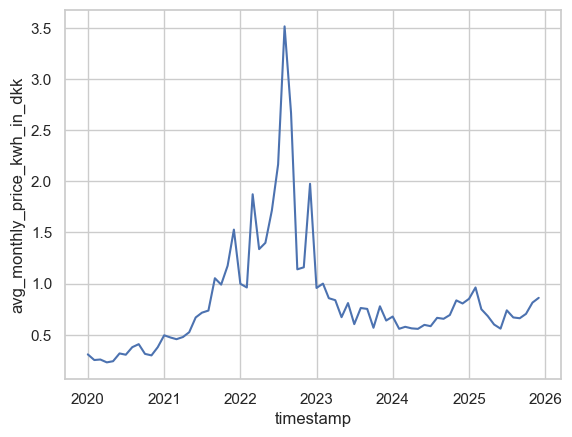

In [8]:
df = (
    joined_df
    .group_by(pl.col(Column.TIMESTAMP).dt.truncate("1mo"), maintain_order=True)
    .agg(pl.col(Column.HOURLY_PRICE).mean().alias(Column.MONTHLY_PRICE_AVG))
)
sns.lineplot(data=df, x=Column.TIMESTAMP, y=Column.MONTHLY_PRICE_AVG)

# Monthly Power Cost

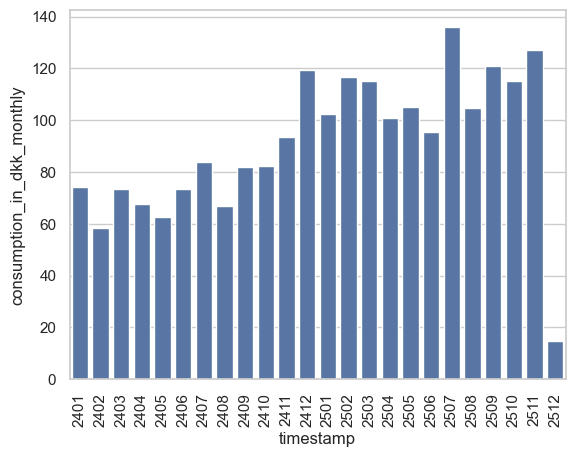

In [9]:
df = (
    joined_df.filter(pl.col(Column.TIMESTAMP).dt.year() >= 2024)
    .group_by(pl.col(Column.TIMESTAMP).dt.truncate("1mo"), maintain_order=True)
    .agg(pl.col(Column.HOURLY_TOTAL_COST).sum().alias(Column.MONTHLY_TOTAL_COST))
)
sns.barplot(data=df, x=Column.TIMESTAMP, y=Column.MONTHLY_TOTAL_COST)
plt.xticks(
    ticks=range(len(df)),
    labels=df[Column.TIMESTAMP].dt.strftime("%y%m").cast(pl.Int64()).to_list(),
    rotation=90,
    ha='center'
);  # 45 degrees, aligned right


# Power curve

<Axes: xlabel='hour_of_day', ylabel='consumption_kwh_hourly'>

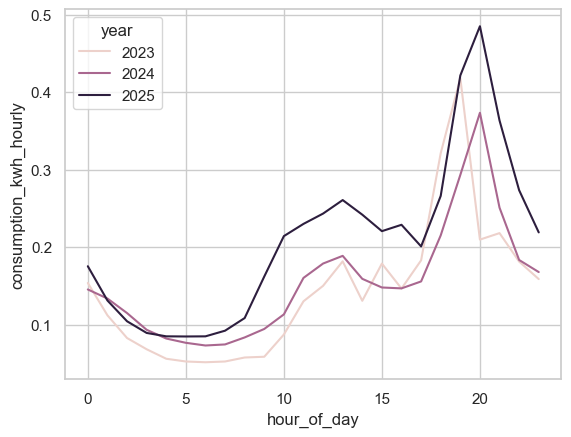

In [10]:
df = (
    joined_df
    .filter(pl.col(Column.HOURLY_CONSUMPTION) > 0)
    .group_by(FeatureColumn.YEAR, FeatureColumn.HOUR_OF_DAY)
    .agg(pl.mean(Column.HOURLY_CONSUMPTION))
    .sort(FeatureColumn.HOUR_OF_DAY)
)
sns.lineplot(data=df, x=FeatureColumn.HOUR_OF_DAY, y=Column.HOURLY_CONSUMPTION, hue=FeatureColumn.YEAR)

<Axes: xlabel='hour_of_day', ylabel='consumption_kwh_hourly'>

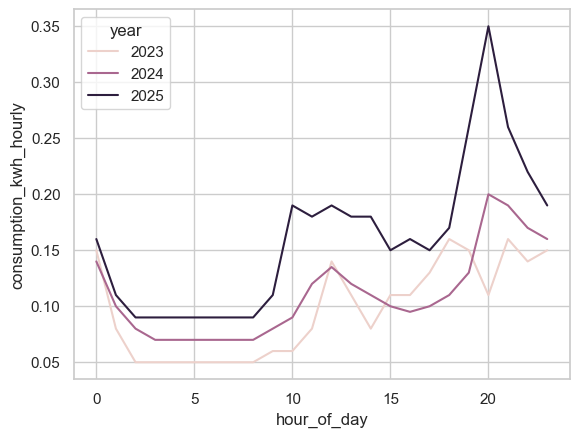

In [11]:
df = (
    joined_df
    .filter(pl.col(Column.HOURLY_CONSUMPTION) > 0)
    .group_by(FeatureColumn.YEAR, FeatureColumn.HOUR_OF_DAY)
    .agg(pl.median(Column.HOURLY_CONSUMPTION))
    .sort(FeatureColumn.HOUR_OF_DAY)
)
sns.lineplot(data=df, x=FeatureColumn.HOUR_OF_DAY, y=Column.HOURLY_CONSUMPTION, hue=FeatureColumn.YEAR)

# Significant Consumption

<Axes: xlabel='hour_of_day', ylabel='significant_consumption'>

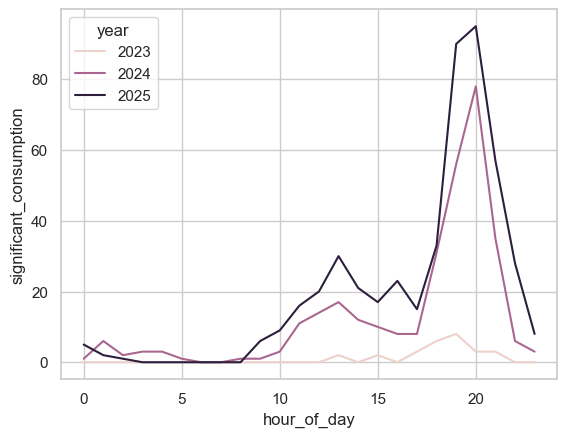

In [12]:
df = (
    joined_df
    .filter(pl.col(Column.HOURLY_CONSUMPTION) > 0)
    .group_by(FeatureColumn.YEAR, FeatureColumn.HOUR_OF_DAY)
    .agg(pl.sum(FeatureColumn.SIGNIFICANT_CONSUMPTION))
    .sort(FeatureColumn.HOUR_OF_DAY)
)
sns.lineplot(
    data=df,
    x=FeatureColumn.HOUR_OF_DAY,
    y=FeatureColumn.SIGNIFICANT_CONSUMPTION,
    hue=FeatureColumn.YEAR
)

In [22]:
joined_df.with_columns(
        pl.when(pl.col(FeatureColumn.WEEKDAY) <= 5)
        .then(pl.lit(1))
        .otherwise(pl.col(FeatureColumn.WEEKDAY)).alias(FeatureColumn.WEEKDAY)
    ).filter(pl.col(Column.HOURLY_CONSUMPTION) > 0)[FeatureColumn.WEEKDAY].unique()

weekday
i8
1
6
7


<Axes: xlabel='hour_of_day', ylabel='consumption_kwh_hourly'>

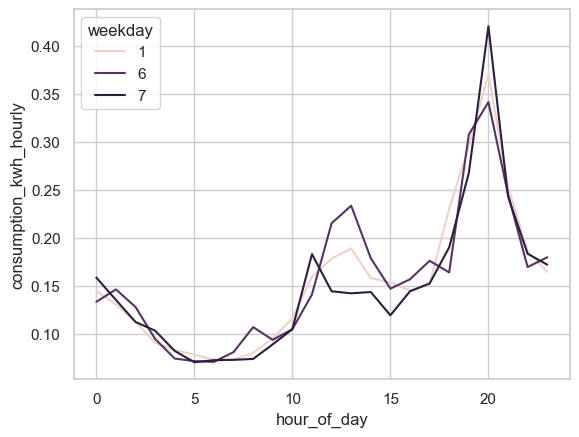

In [36]:
df = (
    joined_df
    .with_columns(
        pl.when(pl.col(FeatureColumn.WEEKDAY) <= 5)
        .then(pl.lit(1))
        .otherwise(pl.col(FeatureColumn.WEEKDAY)).alias(FeatureColumn.WEEKDAY)
    )
    .filter(pl.col(Column.HOURLY_CONSUMPTION) > 0)
    .filter(pl.col(FeatureColumn.YEAR) == 2024)
    .group_by(FeatureColumn.WEEKDAY, FeatureColumn.HOUR_OF_DAY)
    .agg(pl.mean(Column.HOURLY_CONSUMPTION))
    .sort(FeatureColumn.HOUR_OF_DAY)
)
sns.lineplot(
    data=df,
    x=FeatureColumn.HOUR_OF_DAY,
    y=Column.HOURLY_CONSUMPTION,
    hue=FeatureColumn.WEEKDAY
)

<Axes: xlabel='hour_of_day', ylabel='consumption_kwh_hourly'>

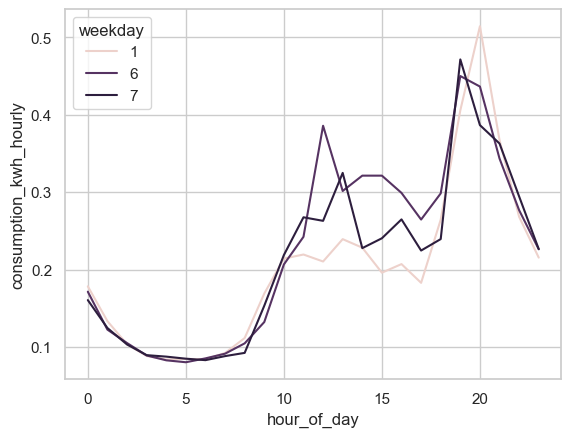

In [35]:
df = (
    joined_df
    .with_columns(
        pl.when(pl.col(FeatureColumn.WEEKDAY) <= 5)
        .then(pl.lit(1))
        .otherwise(pl.col(FeatureColumn.WEEKDAY)).alias(FeatureColumn.WEEKDAY)
    )
    .filter(pl.col(Column.HOURLY_CONSUMPTION) > 0)
    .filter(pl.col(FeatureColumn.YEAR) == 2025)
    .group_by(FeatureColumn.WEEKDAY, FeatureColumn.HOUR_OF_DAY)
    .agg(pl.mean(Column.HOURLY_CONSUMPTION))
    .sort(FeatureColumn.HOUR_OF_DAY)
)
sns.lineplot(
    data=df,
    x=FeatureColumn.HOUR_OF_DAY,
    y=Column.HOURLY_CONSUMPTION,
    hue=FeatureColumn.WEEKDAY
)

# What if analysis

In [14]:
what_if_df = join_prices_and_consumption_data(
    daily_prices_df=prices_df,
    daily_consumption_df=consumption_df.with_columns(pl.col(Column.UTC_TIME).dt.offset_by("-2y")),
    monthly_prices_df=None
)
what_if_df = (
    what_if_df
    .filter(pl.col(Column.HOURLY_CONSUMPTION).is_not_null())
    .sort(Column.UTC_TIME)
    .with_columns(
      pl.col(Column.HOURLY_CONSUMPTION)
      .rolling_sum_by(Column.UTC_TIME, window_size="1mo")
      .alias(Column.HOURLY_CONSUMPTION_ROLLING_SUM)
    )
)
what_if_df.head()

HourUTC,price_kwh_in_dkk,consumption_kwh_hourly,timestamp,hour_of_day,day_of_month,month,year,weekday,event_of_day,consumption_in_dkk,consumption_kwh_hourly_diff,significant_consumption,consumption_in_dkk_rolling_sum
datetime[μs],f64,f64,"datetime[μs, Europe/Copenhagen]",i8,i8,i8,i32,i8,str,f64,f64,bool,f64
2021-12-01 00:00:00,0.91573,0.05,2021-12-01 01:00:00 CET,1,1,12,2021,3,"""Night""",0.045786,-0.15059,false,0.05
2021-12-01 01:00:00,0.84426,0.05,2021-12-01 02:00:00 CET,2,1,12,2021,3,"""Night""",0.042213,-0.07147,false,0.1
2021-12-01 02:00:00,0.81883,0.04,2021-12-01 03:00:00 CET,3,1,12,2021,3,"""Night""",0.032753,-0.02543,false,0.14
2021-12-01 03:00:00,0.76595,0.05,2021-12-01 04:00:00 CET,4,1,12,2021,3,"""Night""",0.038298,-0.05288,false,0.19
2021-12-01 04:00:00,0.82106,0.05,2021-12-01 05:00:00 CET,5,1,12,2021,3,"""Night""",0.041053,0.05511,false,0.24


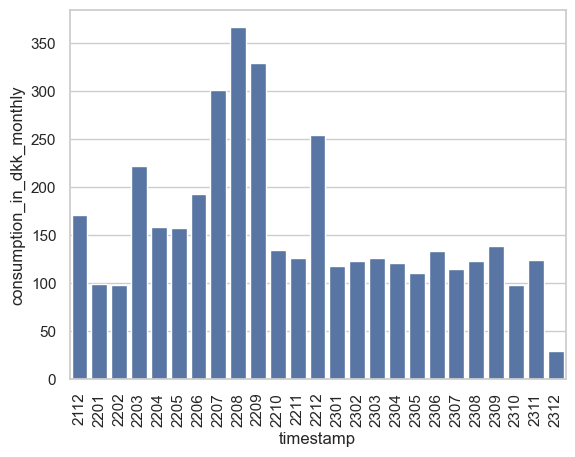

In [15]:
df = (
    what_if_df
    .group_by(pl.col(Column.TIMESTAMP).dt.truncate("1mo"), maintain_order=True)
    .agg(pl.col(Column.HOURLY_TOTAL_COST).sum().alias(Column.MONTHLY_TOTAL_COST))
    .filter(pl.col(Column.MONTHLY_TOTAL_COST) > 0)
)
sns.barplot(data=df, x=Column.TIMESTAMP, y=Column.MONTHLY_TOTAL_COST)
plt.xticks(
    ticks=range(len(df)),
    labels=df[Column.TIMESTAMP].dt.strftime("%y%m").cast(pl.Int64()).to_list(),
    rotation=90,
    ha='center'
);  # 45 degrees, aligned right


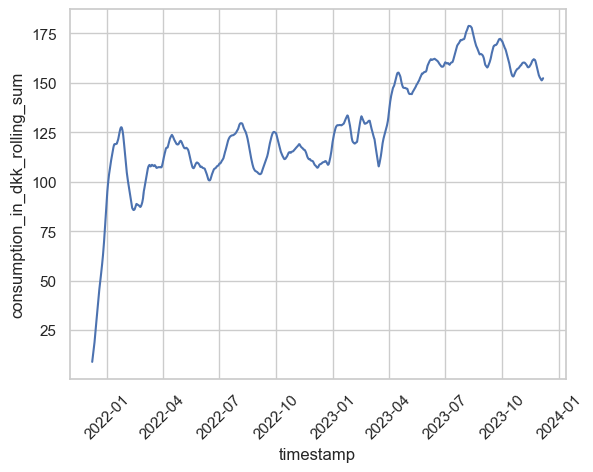

In [16]:
df = what_if_df.with_columns(pl.col(Column.HOURLY_CONSUMPTION_ROLLING_SUM).rolling_mean(window_size=7 * 24))
sns.lineplot(data=df, x=Column.TIMESTAMP, y=Column.HOURLY_CONSUMPTION_ROLLING_SUM)
plt.xticks(
    rotation=45,
    ha='center'
);  # 45 degrees, aligned right